Here, we would like to implement a multivariate time series LSTM model that utilizes historical prices along with technical indicators to predict prices.

<img src="https://api.wandb.ai/files/ayush-thakur/images/projects/103390/4fc355be.png" width=500 height=300>

In [1]:
import os
import numpy as np
from Functions.sp500.sp500 import get_sp500_tickers
import matplotlib.pyplot as plt

In [2]:
def load_data(tickers):
    final_X, final_y = None, None
    for ticker in tickers:
        print(f"Loading {ticker}")
        a = f"../Functions/csv_files/sampling_data/{ticker}/X.npy"
        b = f"../Functions/csv_files/sampling_data/{ticker}/y.npy"
        if not os.path.exists(a) or not os.path.exists(b):
            print(f"No {ticker} data")
            continue
        data_X = np.load(a, allow_pickle=True)
        data_y = np.load(b, allow_pickle=True)
        if len(data_X.shape) != 3 or data_X.shape[1] != 14 or data_X.shape[2] != 7:
            print(f"{ticker} is corrupted: Training Data is incorrect")
            continue
        if len(data_y.shape) != 1 or data_y.shape[0] != data_X.shape[0]:
            print(f"{ticker} is corrupted: Label is incorrect")
            continue
        if final_X is None and final_y is None:
            final_X = data_X
            final_y = data_y
        else:
            final_X = np.append(final_X, data_X, axis=0)
            final_y = np.append(final_y, data_y, axis=0)
    return final_X, final_y

In [3]:
tickers = get_sp500_tickers(False)
end = tickers.index("WTW.US")
tickers = tickers[:end]
print(tickers)

['AAPL.US', 'MSFT.US', 'AMZN.US', 'TSLA.US', 'GOOGL.US', 'GOOG.US', 'BRKB.US', 'UNH.US', 'JNJ.US', 'XOM.US', 'META.US', 'JPM.US', 'NVDA.US', 'PG.US', 'V.US', 'HD.US', 'CVX.US', 'LLY.US', 'PFE.US', 'MA.US', 'ABBV.US', 'PEP.US', 'MRK.US', 'KO.US', 'BAC.US', 'COST.US', 'TMO.US', 'WMT.US', 'AVGO.US', 'DIS.US', 'MCD.US', 'ABT.US', 'DHR.US', 'CSCO.US', 'ACN.US', 'VZ.US', 'NEE.US', 'WFC.US', 'BMY.US', 'CRM.US', 'TXN.US', 'LIN.US', 'COP.US', 'CMCSA.US', 'ADBE.US', 'PM.US', 'QCOM.US', 'CVS.US', 'UNP.US', 'RTX.US', 'AMGN.US', 'LOW.US', 'UPS.US', 'HON.US', 'SCHW.US', 'T.US', 'ELV.US', 'INTU.US', 'IBM.US', 'MDT.US', 'INTC.US', 'MS.US', 'NKE.US', 'NFLX.US', 'SPGI.US', 'AMD.US', 'GS.US', 'AMT.US', 'PYPL.US', 'SBUX.US', 'ADP.US', 'DE.US', 'ORCL.US', 'LMT.US', 'CAT.US', 'CI.US', 'BLK.US', 'AXP.US', 'TMUS.US', 'C.US', 'GILD.US', 'NOW.US', 'CB.US', 'PLD.US', 'MDLZ.US', 'MMC.US', 'VRTX.US', 'REGN.US', 'ADI.US', 'TJX.US', 'MO.US', 'SO.US', 'DUK.US', 'AMAT.US', 'ZTS.US', 'TGT.US', 'NOC.US', 'SYK.US', 'PGR.

In [4]:
X, y = load_data(tickers)

Loading AAPL.US
Loading MSFT.US
Loading AMZN.US
Loading TSLA.US
Loading GOOGL.US
Loading GOOG.US
Loading BRKB.US
Loading UNH.US
Loading JNJ.US
Loading XOM.US
Loading META.US
Loading JPM.US
Loading NVDA.US
Loading PG.US
Loading V.US
Loading HD.US
Loading CVX.US
Loading LLY.US
Loading PFE.US
Loading MA.US
Loading ABBV.US
Loading PEP.US
Loading MRK.US
Loading KO.US
Loading BAC.US
Loading COST.US
Loading TMO.US
Loading WMT.US
Loading AVGO.US
Loading DIS.US
Loading MCD.US
Loading ABT.US
Loading DHR.US
Loading CSCO.US
Loading ACN.US
Loading VZ.US
Loading NEE.US
Loading WFC.US
Loading BMY.US
Loading CRM.US
Loading TXN.US
Loading LIN.US
Loading COP.US
Loading CMCSA.US
Loading ADBE.US
Loading PM.US
Loading QCOM.US
Loading CVS.US
Loading UNP.US
Loading RTX.US
Loading AMGN.US
Loading LOW.US
Loading UPS.US
Loading HON.US
Loading SCHW.US
Loading T.US
Loading ELV.US
Loading INTU.US
Loading IBM.US
Loading MDT.US
Loading INTC.US
Loading MS.US
Loading NKE.US
Loading NFLX.US
Loading SPGI.US
Loading AMD.

In [5]:
def remove_date(X):
    X_train = np.delete(X, 0, 2)
    X_train = np.asarray(X_train).astype(np.float32)
    return X_train
X_train = remove_date(X)

In [6]:
def plot_history(history):
# summarize history for accuracy
          
    legend = ['train']
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if "val_loss" in history.history.keys():
        plt.plot(history.history['val_loss'])
        legend.append('val')
          
    # summarize history for loss

    plt.legend(legend, loc='upper left')
    plt.show()    

In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

<h1>Control Model</h1>

This control model accepts historical prices as the only feature only. It will be used to create a benchmark for future models.

In [22]:
X_train_control = X_train[:,:,0]
X_train_control.shape

(6675, 14)

In [24]:
control_model = Sequential()
control_model.add(LSTM(32, activation='relu', input_shape=(14, 1)))
control_model.add(Dense(1))
control_model.compile(optimizer='adam', loss='mse')

control_history = control_model.fit(X_train_control, y, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
167/167 [==============================] - 3s 10ms/step - loss: 7065.1499 - val_loss: 115.0388
Epoch 2/30
167/167 [==============================] - 2s 9ms/step - loss: 148.4204 - val_loss: 45.1453
Epoch 3/30
167/167 [==============================] - 1s 9ms/step - loss: 265.3380 - val_loss: 33.0410
Epoch 4/30
167/167 [==============================] - 1s 9ms/step - loss: 471.6122 - val_loss: 55.5360
Epoch 5/30
167/167 [==============================] - 1s 8ms/step - loss: 1571.0179 - val_loss: 41.2476
Epoch 6/30
167/167 [==============================] - 1s 8ms/step - loss: 105.9424 - val_loss: 35.5950
Epoch 7/30
167/167 [==============================] - 1s 9ms/step - loss: 218.2288 - val_loss: 79.8542
Epoch 8/30
167/167 [==============================] - 1s 9ms/step - loss: 260.7164 - val_loss: 52.9260
Epoch 9/30
167/167 [==============================] - 1s 9ms/step - loss: 188.9857 - val_loss: 48.4082
Epoch 10/30
167/167 [==============================] - 1s 9ms/step - 

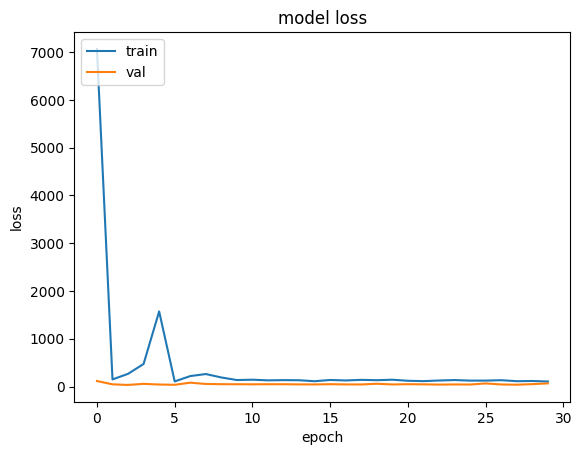

In [40]:
plot_history(control_history)

<h1>Data Exploration</h1>

In [75]:
import datetime as dt
dates = [dt.datetime.strptime(i[0], "%Y-%m-%d").date() for i in X[:,0,:]]

In [87]:
from collections import Counter
count_date = dict(Counter(dates))

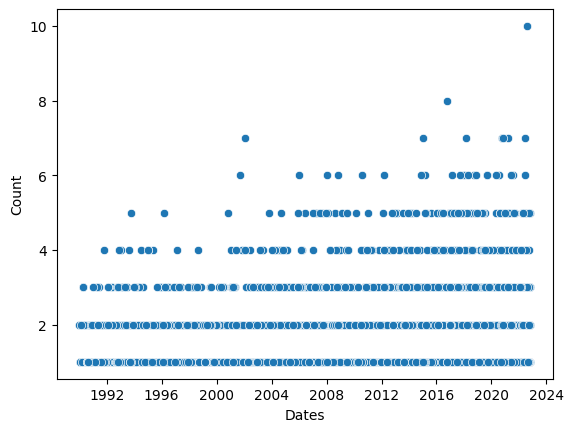

In [89]:
import seaborn as sns
ax = sns.scatterplot(x=count_date.keys(), y=count_date.values())
ax.set(xlabel='Dates', ylabel='Count')
plt.show()

The distribution of data is relatively even, Although it's skewed towards more recent dates.

<h1>Data Transformation</h1>

In [100]:
sample = X_train[0]

In [102]:
sample

array([[3.590850e+01, 1.950096e+08, 3.445640e+01, 1.639000e-01,
        7.583090e+01, 5.258000e-01],
       [3.613850e+01, 1.565216e+08, 3.472800e+01, 1.863000e-01,
        7.728230e+01, 6.881000e-01],
       [3.596720e+01, 1.032228e+08, 3.494700e+01, 2.037000e-01,
        7.373100e+01, 7.906000e-01],
       [3.627820e+01, 1.090204e+08, 3.518340e+01, 2.175000e-01,
        7.589660e+01, 8.831000e-01],
       [3.678490e+01, 1.301080e+08, 3.545970e+01, 2.436000e-01,
        7.894240e+01, 1.069900e+00],
       [3.669060e+01, 1.040388e+08, 3.569420e+01, 2.605000e-01,
        7.699250e+01, 1.178300e+00],
       [3.663640e+01, 8.019400e+07, 3.589510e+01, 2.570000e-01,
        7.583300e+01, 1.154800e+00],
       [3.540630e+01, 2.030708e+08, 3.590420e+01, 2.064000e-01,
        5.543100e+01, 9.596000e-01],
       [3.594600e+01, 1.342728e+08, 3.596940e+01, 1.628000e-01,
        6.045760e+01, 7.337000e-01],
       [3.606850e+01, 1.078432e+08, 3.602960e+01, 1.356000e-01,
        6.151850e+01, 6.283

In [105]:
from sklearn.preprocessing import MinMaxScaler

def scale_column(x, column = 1):
    """
    Doesn't mutate the original array
    """
    mms = MinMaxScaler()
    x2 = x.copy()
    # The volume column has index 1
    x2[:, 1] = mms.fit_transform(x2[:, column].reshape(14, 1)).reshape(14,)
    return x2

In [106]:
scale_column(sample)

array([[3.5908501e+01, 9.3620390e-01, 3.4456402e+01, 1.6390000e-01,
        7.5830902e+01, 5.2579999e-01],
       [3.6138500e+01, 6.3161093e-01, 3.4728001e+01, 1.8629999e-01,
        7.7282303e+01, 6.8809998e-01],
       [3.5967201e+01, 2.0980573e-01, 3.4946999e+01, 2.0370001e-01,
        7.3731003e+01, 7.9060000e-01],
       [3.6278198e+01, 2.5568777e-01, 3.5183399e+01, 2.1750000e-01,
        7.5896599e+01, 8.8309997e-01],
       [3.6784901e+01, 4.2257446e-01, 3.5459702e+01, 2.4360000e-01,
        7.8942398e+01, 1.0699000e+00],
       [3.6690601e+01, 2.1626353e-01, 3.5694199e+01, 2.6050001e-01,
        7.6992500e+01, 1.1783000e+00],
       [3.6636398e+01, 2.7556419e-02, 3.5895100e+01, 2.5700000e-01,
        7.5833000e+01, 1.1548001e+00],
       [3.5406300e+01, 9.9999994e-01, 3.5904202e+01, 2.0640001e-01,
        5.5431000e+01, 9.5959997e-01],
       [3.5945999e+01, 4.5553452e-01, 3.5969398e+01, 1.6280000e-01,
        6.0457600e+01, 7.3369998e-01],
       [3.6068501e+01, 2.4637145e-01,

In [107]:
check_rsi = lambda rsi: 1 if rsi > 70 else (-1 if rsi < 30 else 0)
"""
Traditionally, RSI > 70 = Overbought, RSI < 30 Oversold
We transform the column to -1, 0, 1,
"""
vectorized_check_rsi = np.vectorize(check_rsi)

def rsi_transformer(x):
    x2 = x.copy()
    rsi_column = x2[:, 4]
    x2[:, 4] = vectorized_check_rsi(rsi_column)
    return x2

In [98]:
rsi_transformer(sample)

array([[3.590850e+01, 1.950096e+08, 3.445640e+01, 1.639000e-01,
        1.000000e+00, 5.258000e-01],
       [3.613850e+01, 1.565216e+08, 3.472800e+01, 1.863000e-01,
        1.000000e+00, 6.881000e-01],
       [3.596720e+01, 1.032228e+08, 3.494700e+01, 2.037000e-01,
        1.000000e+00, 7.906000e-01],
       [3.627820e+01, 1.090204e+08, 3.518340e+01, 2.175000e-01,
        1.000000e+00, 8.831000e-01],
       [3.678490e+01, 1.301080e+08, 3.545970e+01, 2.436000e-01,
        1.000000e+00, 1.069900e+00],
       [3.669060e+01, 1.040388e+08, 3.569420e+01, 2.605000e-01,
        1.000000e+00, 1.178300e+00],
       [3.663640e+01, 8.019400e+07, 3.589510e+01, 2.570000e-01,
        1.000000e+00, 1.154800e+00],
       [3.540630e+01, 2.030708e+08, 3.590420e+01, 2.064000e-01,
        0.000000e+00, 9.596000e-01],
       [3.594600e+01, 1.342728e+08, 3.596940e+01, 1.628000e-01,
        0.000000e+00, 7.337000e-01],
       [3.606850e+01, 1.078432e+08, 3.602960e+01, 1.356000e-01,
        0.000000e+00, 6.283

In [47]:
NUM_OF_TIMESTEPS = 14
NUM_OF_FEATURES = 6

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(NUM_OF_TIMESTEPS, NUM_OF_FEATURES)))
model.add(Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                4992      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(optimizer='adam', loss='mse')

In [49]:
history = model.fit(X_train, y, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
167/167 [==============================] - 3s 9ms/step - loss: nan - val_loss: nan
Epoch 2/30
167/167 [==============================] - 1s 8ms/step - loss: nan - val_loss: nan
Epoch 3/30
167/167 [==============================] - 1s 8ms/step - loss: nan - val_loss: nan
Epoch 4/30
167/167 [==============================] - 1s 8ms/step - loss: nan - val_loss: nan
Epoch 5/30
167/167 [==============================] - 1s 9ms/step - loss: nan - val_loss: nan
Epoch 6/30
167/167 [==============================] - 1s 8ms/step - loss: nan - val_loss: nan
Epoch 7/30
167/167 [==============================] - 1s 8ms/step - loss: nan - val_loss: nan
Epoch 8/30
167/167 [==============================] - 1s 9ms/step - loss: nan - val_loss: nan
Epoch 9/30
167/167 [==============================] - 1s 8ms/step - loss: nan - val_loss: nan
Epoch 10/30
167/167 [==============================] - 1s 8ms/step - loss: nan - val_loss: nan
Epoch 11/30
167/167 [==============================] - 1s 9

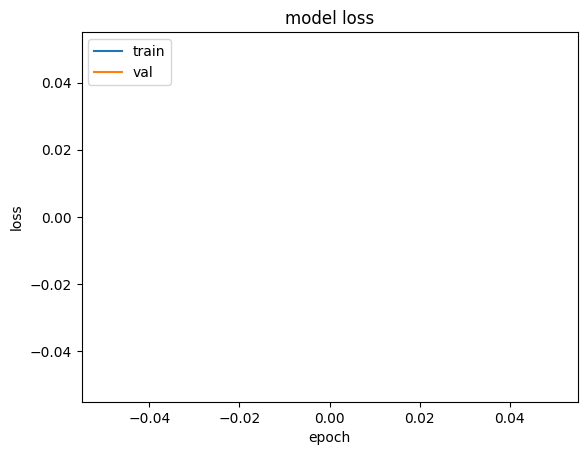

In [51]:
plot_history(history)

In [41]:
model.predict([X_train[0]])

ValueError: in user code:

    File "C:\Users\Admin\Desktop\Equities_Price_Prediction_XAI\venv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\Desktop\Equities_Price_Prediction_XAI\venv\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\Desktop\Equities_Price_Prediction_XAI\venv\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Admin\Desktop\Equities_Price_Prediction_XAI\venv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\Admin\Desktop\Equities_Price_Prediction_XAI\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Admin\Desktop\Equities_Price_Prediction_XAI\venv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 14, 5), found shape=(None, 5)
